# **Breast Cancer - Grad-CAM Project**

Dataset link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In this project will be used: 
* Magnification factor is 400x.
* CNN: EfficientNetB0

In [1]:
import os
import random
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import matplotlib.cm as cm

import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision, layers, Sequential
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.io as tfio
import cv2 as cv

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Walk through directories
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/train_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/validation_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/train_set/'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/benign'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/malignant'.


There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/validation_set/'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/benign'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/malignant'.


In [4]:
# loading directories
train_dir = 'SiDi_BreakHis400x_Balanceado/train_set/'
val_dir = 'SiDi_BreakHis400x_Balanceado/validation_set/'
test_dir = 'SiDi_BreCaHAD_test/dataset/'
annotated_dir = 'SiDi_BreCaHAD_test/groundTruth_display/'

In [5]:
# loading data
IMG_SIZE=(224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, 
                                                                 label_mode="categorical")
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir, image_size=IMG_SIZE, 
                                                               label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, 
                                                               label_mode="categorical")

Found 2074 files belonging to 2 classes.
Found 360 files belonging to 2 classes.
Found 159 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_names

['benign', 'malignant']

In [7]:
# Function to see random image
def view_random_image(target_dir):
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_dir), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_dir + random_image[0])
    plt.imshow(img)
    plt.title(f'{target_dir.split("/")[1]}\n{img.shape}')
    plt.axis('off');
    
    return img

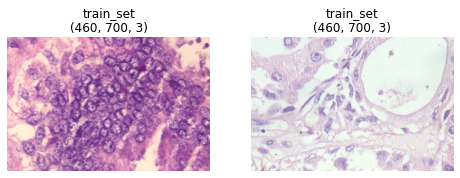

In [8]:
# view random image from training dataset
plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
img1 = view_random_image('SiDi_BreakHis400x_Balanceado/train_set/benign/')

plt.subplot(1,2,2)
img2 = view_random_image('SiDi_BreakHis400x_Balanceado/train_set/malignant/')

## Creating Modelling Callbacks 

In [9]:
# Setup Earlystopping callback to stop training if model's val_accuracy doesn't improve for 5 epochs
ea = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, patience=7)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

## Setting Mixed Precision

In [10]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [11]:
# # Create data augmentation to incorporate it right into the model
# data_augmentation = Sequential([
#     preprocessing.RandomFlip(),
# #     preprocessing.RandomZoom(0.2),
#     preprocessing.RandomWidth(0.2),
#     preprocessing.RandomHeight(0.2),
# #     preprocessing.RandomRotation(20),
# #     preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
# #     preprocessing.Rescaling(1/255.)
# ], name='data_augmentation')

## Building Feature Extraction Model 

In [18]:
# Create base model
input_shape = (224,224,3)

# Create Functional Model

inputs = layers.Input(shape=input_shape, name='input_layer')
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs)
base_model.trainable = False
x = layers.GlobalAvgPool2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(2, activation='softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs, name='efficientB0_model')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [19]:
# model summary
model.summary()

Model: "efficientB0_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                  

In [20]:
# Fitting the model
warnings.filterwarnings('ignore')

history_base = model.fit(train_data, epochs=50, steps_per_epoch=len(train_data), validation_data=val_data,
                        validation_steps=len(val_data), callbacks=[ea])

Epoch 1/50
65/65 [==============================] - 21s 240ms/step - loss: 0.3175 - accuracy: 0.8529 - val_loss: 0.4487 - val_accuracy: 0.8111
Epoch 2/50
65/65 [==============================] - 15s 219ms/step - loss: 0.2053 - accuracy: 0.9161 - val_loss: 0.3614 - val_accuracy: 0.8583
Epoch 3/50
65/65 [==============================] - 15s 219ms/step - loss: 0.1786 - accuracy: 0.9286 - val_loss: 0.3469 - val_accuracy: 0.8556
Epoch 4/50
65/65 [==============================] - 15s 221ms/step - loss: 0.1450 - accuracy: 0.9402 - val_loss: 0.3104 - val_accuracy: 0.8694
Epoch 5/50
65/65 [==============================] - 15s 221ms/step - loss: 0.1354 - accuracy: 0.9417 - val_loss: 0.3064 - val_accuracy: 0.8722
Epoch 6/50
65/65 [==============================] - 15s 221ms/step - loss: 0.1182 - accuracy: 0.9508 - val_loss: 0.2631 - val_accuracy: 0.8917
Epoch 7/50
65/65 [==============================] - 15s 221ms/step - loss: 0.0981 - accuracy: 0.9638 - val_loss: 0.2981 - val_accuracy: 0.8694

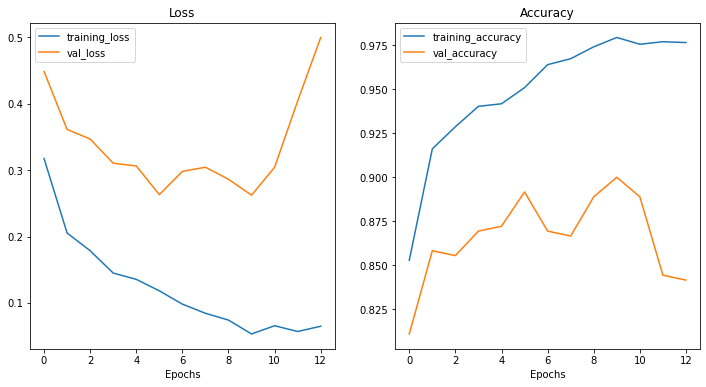

In [21]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_base)

In [22]:
model.evaluate(test_data)

5/5 [==============================] - 4s 171ms/step - loss: 0.6738 - accuracy: 0.7610


[0.6738113164901733, 0.7610062956809998]

## Fine-Tuning the Model 

In [52]:
# To begin fine-tuning, let's start setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze again all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [53]:
# recompile the model lowering the learning rate
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [54]:
model.summary()

Model: "efficientB0_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                  

In [56]:
# Training again
## fine tune for another 5 epochs
init_epochs = 15
ft_epochs = 5

# refitting the model
history_ft = model.fit(train_data, epochs=ft_epochs, steps_per_epoch=len(train_data), validation_data=val_data,
                      initial_epoch=init_epochs, validation_steps=len(val_data), callbacks=[ea, reduce_lr])

In [ ]:
plot_loss_curves(history_ft)

In [ ]:
# evaluating fine tuned model
model.evaluate(test_data)

## Saving Model 

In [23]:
model.save('models/model', save_format='h5')

In [11]:
test_model = tf.keras.models.load_model('models/model')

## Implementing Grad-CAM to the model

Grad-Cam, unlike CAM, uses the gradient information flowing into the last convolutional layer of the CNN to understand each neuron for a decision of interest. 

In [24]:
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_layer')>

In [25]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), base_model.layers))[-1].name
print(last_conv_layer_name) 

top_conv


In [52]:
def get_img_array(img_path, size):

    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [base_model.get_layer(last_conv_layer_name).output, model.output])
           

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [93]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))

    # Remove last layer's softmax
#     model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    model_preds = tf.squeeze(tf.round(preds))
    top_pred_index = tf.argmax(preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    # Display heatmap
#     print(heatmap)
    plt.matshow(heatmap)
    plt.show()
    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [94]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.9, pred=None): #cam_path="saved/teste_1.jpg"
    
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("Reds")
    else:
        jet = cm.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # only for generating images
    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)
    
    # generating mask
    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_RGB2GRAY)
    
    # Otsu's thresholding
    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)


    # Display Grad CAM
    plt.imshow(superimposed_img) # comentar quando for gerar o dataframe
    
    return thresh

## Generating Dataset

In [80]:
def loading_json(filen='SiDi_BreCaHAD_test/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):
            # Opening JSON file
            f = open(filen+item)
            # returns JSON object as 
            # a dictionary
            data = json.load(f)
            
            # adding values to dictionary
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            # creating list to get the annotations coordinates
            x_y = []
            for j, points in enumerate(data['tumor']):
                # list to get the coordinates of one annotation
                values_i_j = []
                
                # the values are multiplied by the image resolution
                values_i_j.append(int(points['x']*1024))
                values_i_j.append(int(points['y']*1360))
                
                # adding the coordinates to the list of one case
                x_y.append(values_i_j)
            
            # adding corresponding annotations to the respective case
            annot_points[item.split('.')[0]] = x_y

            # Closing file
            f.close()
            
    return tumor_cells, annot_points

In [81]:
def getting_probs(filen='BreCaHAD_test_png/'):
    
    # loading test images
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [82]:
def checking_points(annot_points, lst_heatmaps):
    
    # list to check the correct values
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[0]][b[1]] > 0:
                got_it_right += 1
        # adding the correct correspondences to the list      
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [83]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
#     lst_tumors = interpretability(types=lst_classes, hmaps=lst_heatmaps)
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    # tumors found
    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

### Dataset

In [84]:
df = generating_dataset()

In [85]:
df.head(15)

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
0,Case_1-01,140,benign,89.86,59,0
1,Case_1-02,153,malignant,65.76,2,1.31
2,Case_1-03,135,malignant,85.11,25,18.52
3,Case_1-04,103,malignant,93.89,25,24.27
4,Case_1-05,126,benign,57.22,21,0
5,Case_1-06,176,malignant,80.61,7,3.98
6,Case_1-07,196,benign,91.45,114,0
7,Case_1-08,116,malignant,72.42,37,31.9
8,Case_10-01,162,malignant,95.22,9,5.56
9,Case_10-02,139,malignant,87.1,5,3.6


In [88]:
df[df['Interpret. Region Accuracy (%)'] > 50]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
22,Case_11-13,63,malignant,90.74,45,71.43
23,Case_11-15,39,malignant,99.99,24,61.54
52,Case_14-07,72,malignant,84.58,44,61.11
77,Case_16-10,198,malignant,99.08,101,51.01
101,Case_3-01,97,malignant,74.01,60,61.86
109,Case_3-09,97,malignant,94.0,57,58.76
111,Case_4-01,128,malignant,99.98,77,60.16
142,Case_7-07,159,malignant,94.84,93,58.49
145,Case_7-10,80,malignant,99.59,49,61.25


#### Model Metrics

In [90]:
# Interpretability

mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)

print(f'Model Average Interpretability (%): {itp_model} +/- {std_deviation}')

Model Average Interpretability (%): 21.21 +/- 16.69


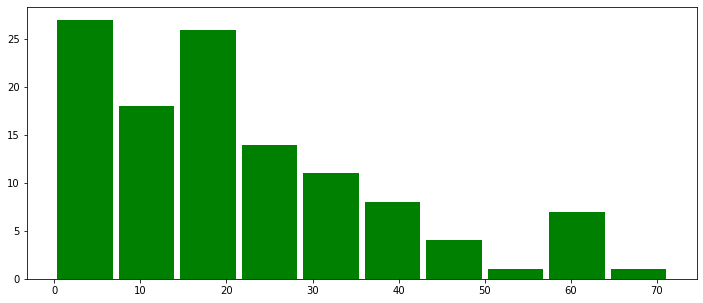

In [91]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9);

In [86]:
np.percentile(values, 98)

95.61399999999999

--------------------------------

-------

------

---------------

## **TEST BAY**

<Figure size 720x360 with 0 Axes>

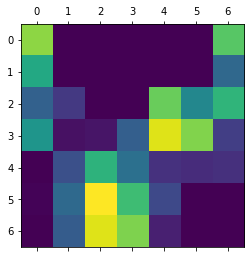

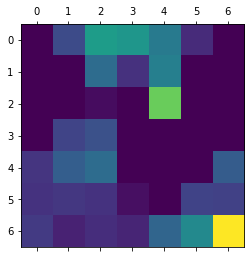

In [102]:
plt.figure(figsize=(10,5))


PATH1 = 'groundTruth_display/Case_7-12.png'
IMG1 = 'BreCaHAD_test_png/Case_7-12.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
heatmap1, class_1, probs1 = generate_heatmap(IMG1)


PATH2 = 'groundTruth_display/Case_1-03.png'
IMG2 = 'BreCaHAD_test_png/Case_1-03.png'
img2 = tf.keras.utils.load_img(PATH2)
img_orig_2 = tf.keras.utils.load_img(IMG2)
heatmap2, class_2, probs2 = generate_heatmap(IMG2)

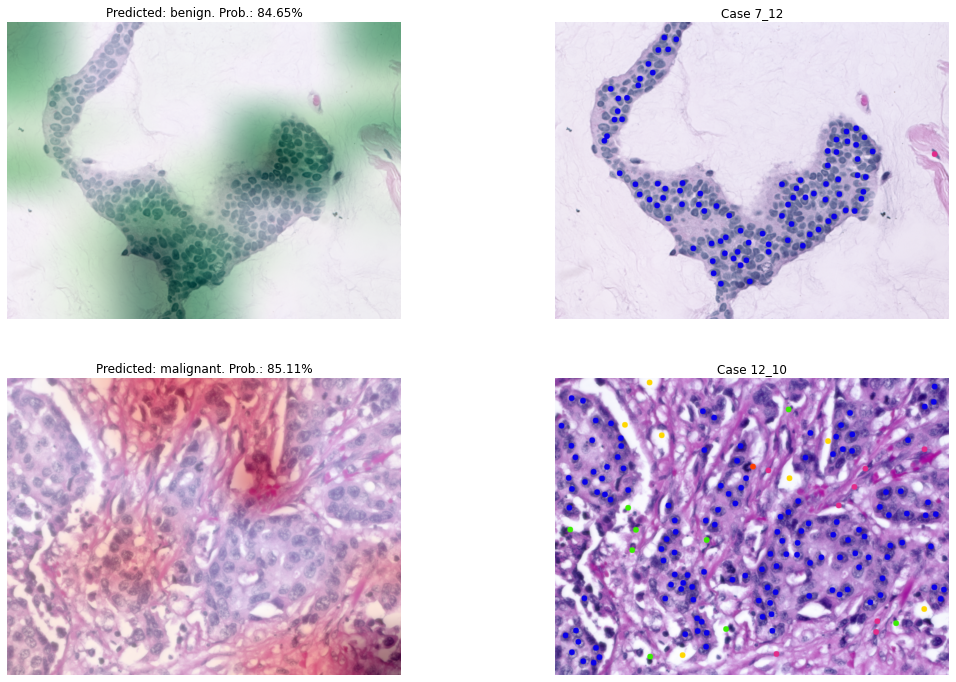

In [106]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,2)
plt.title('Case 7_12')
plt.axis(False)
plt.imshow(img1)

plt.subplot(2,2,3)
plt.title(f'Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
save_and_display_gradcam(img_path=IMG2, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title('Case 12_10')
plt.axis(False)
plt.imshow(img2);

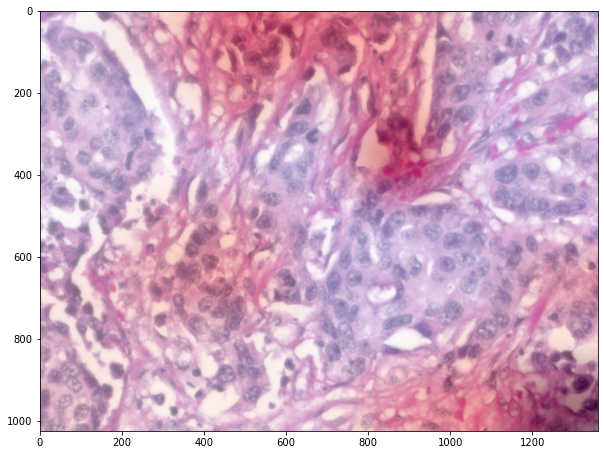

In [41]:
plt.figure(figsize=(10,10))
result = save_and_display_gradcam(img_path=IMG2, heatmap=heatmap2, pred=class_2);

(1024, 1360)


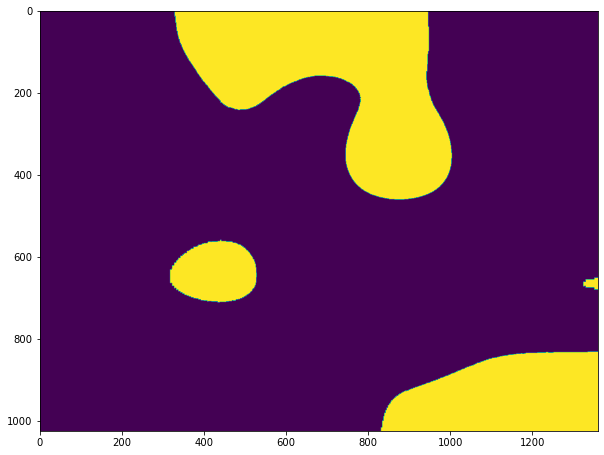

In [42]:
plt.figure(figsize=(10,10))
print(result.shape)

plt.imshow(result)

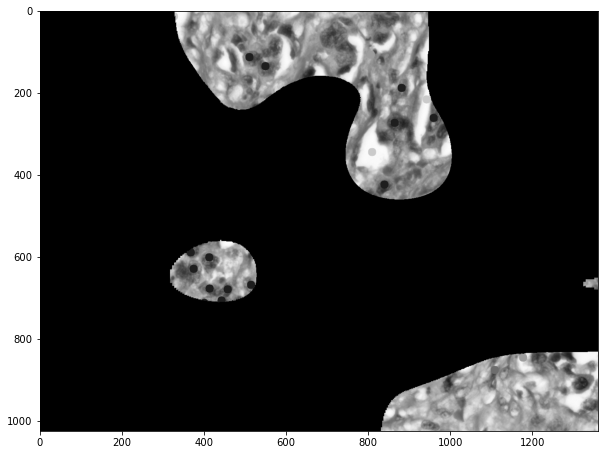

In [43]:
# inverting result mask
plt.figure(figsize=(10,10))
data1 = cv.imread(PATH2)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.imshow(final, cmap='gray')

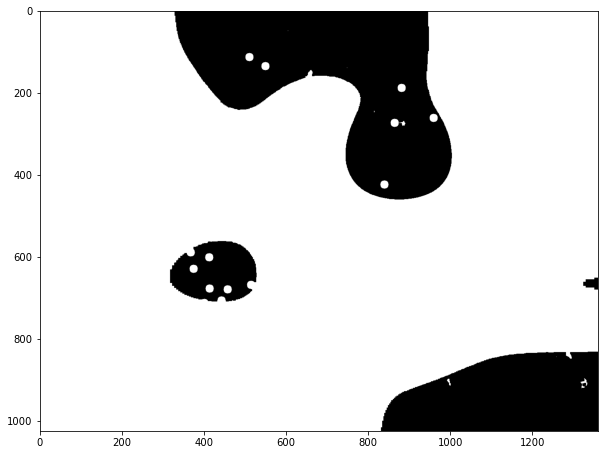

In [44]:
plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,40,255,cv.THRESH_BINARY_INV)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')

(1, 10, 3)


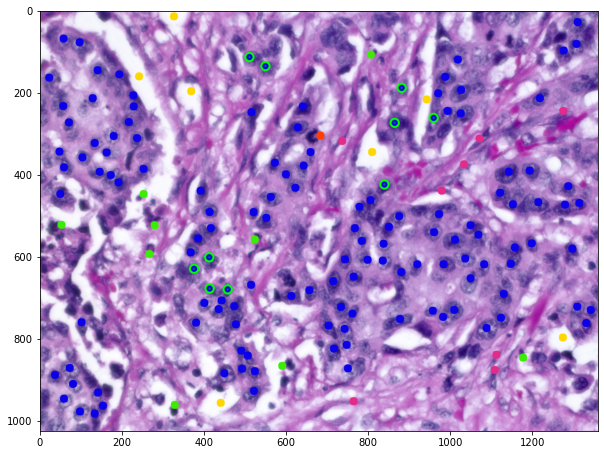

In [45]:
plt.figure(figsize=(10,10))

data2 = data1.copy()

##########
p_edges = cv.Canny(mask2, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=1000, param2=15,
                          minRadius=2, maxRadius=11)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(data2, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(data2, center, radius, (0, 255, 0), 4)

plt.imshow(data2)

In [382]:
def interpretability(filen='groundTruth_display/', types=None, hmaps=None):
    
    values = []
    circles = 0
    for root, dirs, items in os.walk(filen):
        classes = types
        heatmaps = hmaps
        
        for i, item in enumerate(items):
            
            if classes[i] == 'malignant':
                mask = save_and_display_gradcam(img_path='BreCaHAD_test_png/'+item, 
                                               heatmap=heatmaps[i], 
                                               pred='malignant')
                
                # applying mask to image
                img = cv.imread(filen+item)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                masked = cv.bitwise_and(img, img, mask = mask)
                masked = cv.cvtColor(masked, cv.COLOR_RGB2GRAY)
                
                # binary mask
                kernel = np.ones((5,5),np.uint8)
                binary = cv.threshold(masked,40,255,cv.THRESH_BINARY_INV)[1]
                binary = cv.morphologyEx(binary, cv.MORPH_CLOSE, kernel)
                binary = np.uint8(binary)
                
                # counting circles
                ##########
                p_edges = cv.Canny(binary, 0, 255)

                ##########
                rows = p_edges.shape[0]
                circles = cv.HoughCircles(binary, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, 
                                          param1=1000, param2=15,
                                          minRadius=2, maxRadius=11)
                
                if circles is None:
                    num_circles = 0
                    
                else:
                    num_circles = circles.shape[1]
                
            else:
                num_circles = 0
            
            values.append(num_circles)           
                
    return values

# o quanto ele acertou

# do que ele acertou, quão preciso ele foi